In [1]:
import tensorflow as tf
from tensorflow.contrib import slim
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from util import plot

## Setting; parameter & data

In [2]:
mb_size = 32
X_dim = 784
z_dim = 64
h_dim = 128
D_out_dim = X_dim

# lr = 1e-3
lr = 9e-5
lr = 3e-5
gamma = 0.9
lambda_k = 1e-3
k_curr = 0

mnist = input_data.read_data_sets('./data/MNIST', one_hot=True)

save_image_path = 'BEGAN_fixed'

if not os.path.exists('out/{}/'.format(save_image_path)):
    os.makedirs('out/{}/'.format(save_image_path))

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


## Model

In [3]:
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    with tf.variable_scope('G'):
        G_h1 = slim.fully_connected(z, z_dim, activation_fn=tf.nn.relu)
        G_prob = slim.fully_connected(G_h1, X_dim, activation_fn=None)
    return G_prob


def discriminator(x, reuse=False):
    with tf.variable_scope('D', reuse=reuse):
        D_h1 = slim.fully_connected(x, z_dim, activation_fn=tf.nn.relu)
        recon_x = slim.fully_connected(D_h1, D_out_dim, activation_fn=None)
    return recon_x


X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])


G_sample = generator(z)

recon_real = discriminator(X)
recon_fake = discriminator(G_sample, reuse=True)

## Loss  & Optimizer

In [4]:
def AE_loss(x, recon_x):
    # L1_loss
    loss = tf.reduce_mean(tf.reduce_sum(tf.abs(recon_x - x), 1))
    
    # L2_loss
    # loss = tf.reduce_mean(tf.reduce_sum((x - recon_x)**2, 1))
    return loss


D_real = AE_loss(X, recon_real)
D_fake = AE_loss(G_sample, recon_fake)

k = tf.Variable(0., trainable=False)
D_loss = D_real - k * D_fake
G_loss = D_fake


theta_G = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='G')
theta_D = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='D')

D_solver = tf.train.AdamOptimizer(learning_rate=lr).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=lr).minimize(G_loss, var_list=theta_G)


balance = gamma * D_real - D_fake

with tf.control_dependencies([D_solver, G_solver]):
    k_update = tf.assign(k, tf.clip_by_value(k + lambda_k * balance, 0, 1))
    
measure = D_real + tf.abs(balance)

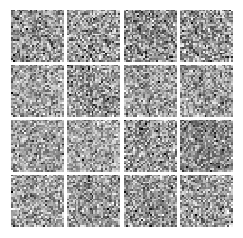

Iter: 0
k_curr: 0.0363
D_loss: 160.4
G_loss: 108.1
measure: 196.7



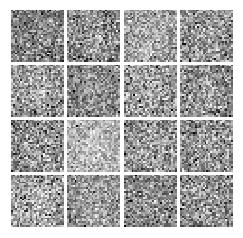

Iter: 1000
k_curr: 1.0
D_loss: 34.06
G_loss: 58.01
measure: 116.9



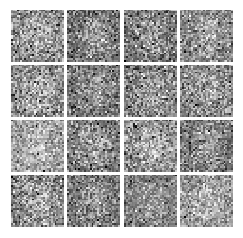

Iter: 2000
k_curr: 1.0
D_loss: 54.44
G_loss: 41.36
measure: 140.7



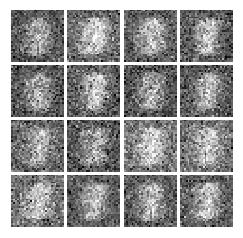

Iter: 3000
k_curr: 1.0
D_loss: 75.25
G_loss: 47.53
measure: 185.7



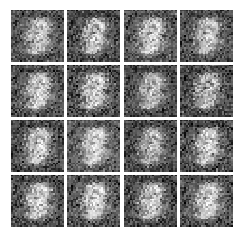

Iter: 4000
k_curr: 1.0
D_loss: 30.13
G_loss: 123.9
measure: 168.8



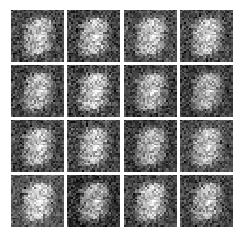

Iter: 5000
k_curr: 0.8442
D_loss: 38.02
G_loss: 142.6
measure: 158.5



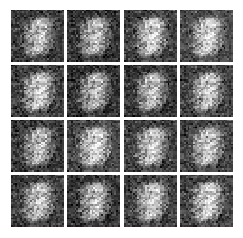

Iter: 6000
k_curr: 0.8437
D_loss: 30.1
G_loss: 156.8
measure: 173.2



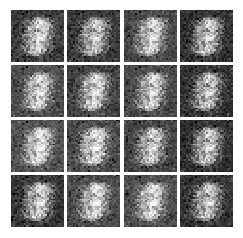

Iter: 7000
k_curr: 0.8074
D_loss: 39.5
G_loss: 124.2
measure: 141.1



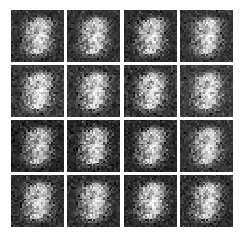

Iter: 8000
k_curr: 0.7484
D_loss: 39.16
G_loss: 118.6
measure: 131.4



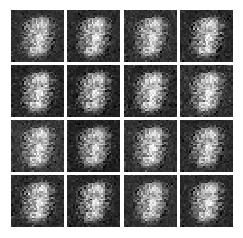

Iter: 9000
k_curr: 0.5872
D_loss: 61.74
G_loss: 108.4
measure: 129.0



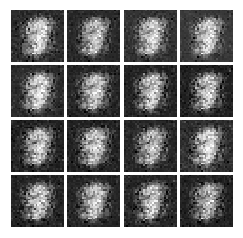

Iter: 10000
k_curr: 0.4466
D_loss: 68.19
G_loss: 102.9
measure: 114.3



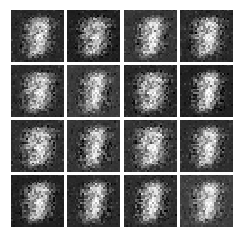

Iter: 11000
k_curr: 0.4379
D_loss: 73.34
G_loss: 102.6
measure: 121.4



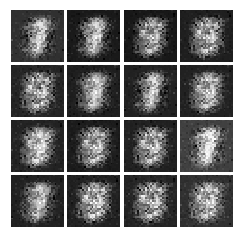

Iter: 12000
k_curr: 0.5189
D_loss: 57.57
G_loss: 99.97
measure: 110.9



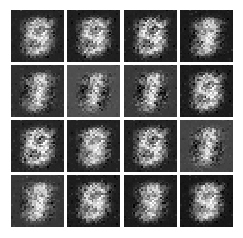

Iter: 13000
k_curr: 0.5657
D_loss: 45.97
G_loss: 108.0
measure: 118.8



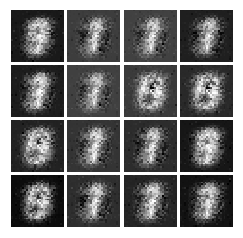

Iter: 14000
k_curr: 0.4959
D_loss: 64.23
G_loss: 101.7
measure: 115.9



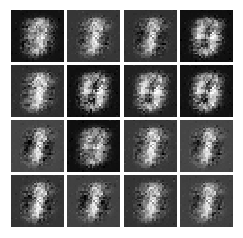

Iter: 15000
k_curr: 0.502
D_loss: 70.67
G_loss: 97.37
measure: 128.0



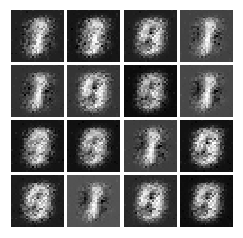

Iter: 16000
k_curr: 0.4962
D_loss: 58.96
G_loss: 102.8
measure: 113.8



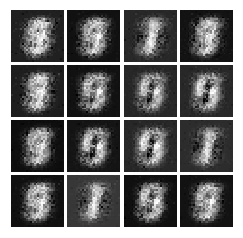

Iter: 17000
k_curr: 0.5327
D_loss: 54.15
G_loss: 100.7
measure: 111.5



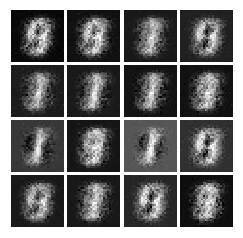

Iter: 18000
k_curr: 0.5709
D_loss: 57.26
G_loss: 95.29
measure: 116.0



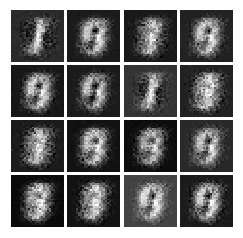

Iter: 19000
k_curr: 0.5761
D_loss: 53.91
G_loss: 95.43
measure: 111.0



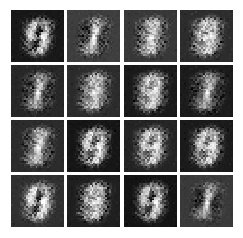

Iter: 20000
k_curr: 0.4535
D_loss: 62.58
G_loss: 96.23
measure: 106.9



In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


for it in range(20001):
    X_mb, _ = mnist.train.next_batch(mb_size)
    
    D_loss_curr, G_loss_curr, measure_curr, _ = sess.run(
        [D_loss, G_loss, measure, k_update],
        feed_dict={X: X_mb, z: sample_z(mb_size, z_dim)}
    )
    

    if it % 1000 == 0:
        
        samples = sess.run(G_sample, feed_dict={z: sample_z(16, z_dim)})

        fig = plot(samples)
        plt.savefig('out/{}/{}.png'.format(save_image_path, str(it//1000).zfill(3)), bbox_inches='tight')
        plt.show()
        plt.close(fig)
        
        print('Iter: {}'.format(it))
        print('k_curr: {:.4}'.format(sess.run(k)))
        print('D_loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('measure: {:.4}'.format(measure_curr))
        print()